In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
anno_path = "/content/drive/MyDrive/techno_pro/data/train_annotations.tsv"

Mounted at /content/drive


In [ ]:
anno_df = pd.read_csv(anno_path, delimiter='\t')
anno_df.head()

,id,label,pattern,semi_major_axis,semi_minor_axis,rotation_angle,x_position,y_position
0,train_0000,1,B,74.84,10.58,-0.49,393.00,85.00
1,train_0001,1,D,28.33,20.01,-0.64,102.36,154.91
2,train_0002,0,A,NaN,NaN,NaN,NaN,NaN
3,train_0003,1,B,33.43,17.73,-0.35,232.00,306.00
4,train_0004,0,A,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 正解ラベル
anno_df["label"].value_counts()

0    4000
1     600
Name: label, dtype: int64

In [ ]:
# パターン
anno_df["pattern"].value_counts()

A    1150
C    1150
B    1150
D    1150
Name: pattern, dtype: int64

In [ ]:
# 数値データに対する統計
anno_df.iloc[:,3:].describe().T

,count,mean,std,min,25%,50%,75%,max
semi_major_axis,600.0,60.239683,21.761635,20.79,44.2575,59.815,73.3050,157.39
semi_minor_axis,600.0,29.258267,15.483290,4.83,17.8500,27.840,35.4400,94.96
rotation_angle,600.0,0.028750,0.858372,-2.37,-0.5825,0.035,0.6100,2.41
x_position,600.0,227.026200,125.532106,24.50,113.8225,210.905,332.1075,496.00
y_position,600.0,241.159317,118.644325,31.93,139.7500,242.550,331.1175,481.50


In [ ]:
# パターン
anno_df[anno_df["label"]==0]["pattern"].value_counts()

A    1000
C    1000
B    1000
D    1000
Name: pattern, dtype: int64

In [ ]:
anno_df[anno_df["label"]==1]["pattern"].value_counts()

A    150
C    150
D    150
B    150
Name: pattern, dtype: int64

In [ ]:
# train, valid分割 → kfにする??
anno_df[["id", "label"]]

,id,label
0,train_0000,1
1,train_0001,1
2,train_0002,0
3,train_0003,1
4,train_0004,0
...,...,...
4595,train_4595,0
4596,train_4596,0
4597,train_4597,0
4598,train_4598,0


In [ ]:
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(anno_df["id"], anno_df["label"]):
  print(anno_df.loc[train_index,"label"].value_counts())
  print(anno_df.loc[test_index,"label"].value_counts())
  print(anno_df.loc[train_index,"pattern"].value_counts())
  print(anno_df.loc[test_index,"pattern"].value_counts())

0    3200
1     480
Name: label, dtype: int64
0    800
1    120
Name: label, dtype: int64
B    926
D    925
C    921
A    908
Name: pattern, dtype: int64
A    242
C    229
D    225
B    224
Name: pattern, dtype: int64
0    3200
1     480
Name: label, dtype: int64
0    800
1    120
Name: label, dtype: int64
B    933
A    926
C    918
D    903
Name: pattern, dtype: int64
D    247
C    232
A    224
B    217
Name: pattern, dtype: int64
0    3200
1     480
Name: label, dtype: int64
0    800
1    120
Name: label, dtype: int64
D    929
C    927
A    914
B    910
Name: pattern, dtype: int64
B    240
A    236
C    223
D    221
Name: pattern, dtype: int64
0    3200
1     480
Name: label, dtype: int64
0    800
1    120
Name: label, dtype: int64
A    940
D    918
C    916
B    906
Name: pattern, dtype: int64
B    244
C    234
D    232
A    210
Name: pattern, dtype: int64
0    3200
1     480
Name: label, dtype: int64
0    800
1    120
Name: label, dtype: int64
B    925
D    925
C    918
A    912
Na

In [ ]:
def preprocess_image(image):
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range
  return image

In [ ]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [ ]:
from tensorflow._api.v2 import image
BATCH_SIZE = 32

# Dataset test
root_path = "/content/drive/MyDrive/techno_pro/data/train/"
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

skf = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(anno_df["id"], anno_df["label"])):

  print("=================== train id: ", i, "===================")
  # Dataset 準備空間
  # Dataset1. image Dataset
  all_image_paths = list(anno_df.loc[train_index,"id"])
  all_image_paths = [str(root_path)+str(path)+".png" for path in all_image_paths]
  # random.shuffle(all_image_paths)
  path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
  image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
  # Dataset2. label Dataset
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(anno_df.loc[train_index,"label"], tf.int64))
  # Dataset3. Xとyの結合
  image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
  print("length of tarin data: ", len(image_label_ds))
  print("batch size(pred): ", len(image_label_ds)/BATCH_SIZE)
  image_label_ds = image_label_ds.shuffle(buffer_size=len(image_label_ds))
  image_label_ds = image_label_ds.batch(BATCH_SIZE)
  image_label_ds = image_label_ds.prefetch(buffer_size=AUTOTUNE)
  print("batch size: ", len(image_label_ds))
  print(image_label_ds)

  # Train 空間

  # Model 保存
  

=================== train id:  0 ===================
length of tarin data:  3680
batch size(pred):  115.0
batch size:  115
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
=================== train id:  1 ===================
length of tarin data:  3680
batch size(pred):  115.0
batch size:  115
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
=================== train id:  2 ===================
length of tarin data:  3680
batch size(pred):  115.0
batch size:  115
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
=================== train id:  3 ===================
length of tarin data:  3680
batch size(pred):  115.0
batch size:  115
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
=================== train id:  4 ===================
length of tarin data:  3680
batch size(pred):  115.0
batch size:  115
<PrefetchDataset shapes: ((None, 

(32, 224, 224, 3)


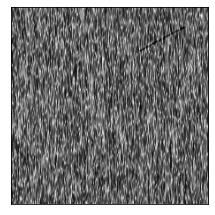

(32, 224, 224, 3)


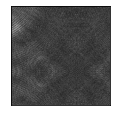

(32, 224, 224, 3)


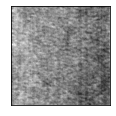

(32, 224, 224, 3)


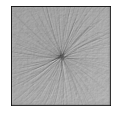

In [ ]:
plt.figure(figsize=(8,8))
for n,imgs in enumerate(image_ds.take(4)):
  print(imgs.shape)
  plt.subplot(2,2,n+1)
  plt.imshow(imgs[0])
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.show()